# Transfer learning - Cats vs. Dogs

Unzip data

In [ ]:
!unzip train.zip -d train/
!unzip test.zip -d test/

Archive:  train.zip
replace train/0.1000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
Archive:  test.zip
replace test/0.1001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Code to initiliaze Tensorflow 2.0 in Colab

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
#%tensorflow_version 2.x
import tensorflow as tf
%load_ext tensorboard
import datetime
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

2024-12-06 11:06:40.693328: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 11:06:40.699954: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-06 11:06:40.759330: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-06 11:06:40.802687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733479600.846558    7335 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733479600.86

**[TODO] Create a data loader function that returns a tuple with a tf.float32 tensor for the image and a label. Images must be resized to 128x128.**
**N.B.: filenames are formatted as class.number.jpg**

In [2]:
def load_and_preprocess_image(filename):  # load images
    image = tf.io.read_file(filename)   # read the raw data from the file as a string
    image = tf.image.decode_jpeg(image, channels=3) # decode the jpeg image to a tensor

    image = tf.image.resize(image, [128, 128])  # resize the image to 128x128
    image = tf.cast(image, tf.float32) / 255.0  # transform the image to a tf.float32 type and normalize it to [0, 1]
    return image

def parse_filename(filename): # load labels 
    label = tf.strings.split(filename, sep='/') # split the filename by '/' (label[0]: 'train', label[1]: 'class.number.jpg')
    label = tf.strings.split(label[-1], sep='.')    # split the last element of the filename by '.' (label[0]: 'class', label[1]: 'number', label[2]: 'jpg')
    label = tf.strings.to_number(label[0], out_type=tf.int32)   # convert the label[0] to a tf.int32 type
    return label

W0000 00:00:1733479607.055101    7335 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


**[TODO] Create a tf.Dataset, map the loader function and prepare a batch object for training**

In [ ]:
trainDataSet = tf.data.Dataset.list_files('train/*')    # create a dataset from the filenames (filename: train/class.number.jpg)
testDataSet = tf.data.Dataset.list_files('test/*')  # create a dataset from the filenames (filename: test/class.number.jpg)
trainDataSet = trainDataSet.map(lambda x: (load_and_preprocess_image(x), parse_filename(x)))    # for each filename, load the image and the label
testDataSet = testDataSet.map(lambda x: (load_and_preprocess_image(x), parse_filename(x)))  # for each filename, load the image and the label

**Prepare Keras callback for Tensorboard**

In [3]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
%tensorboard --logdir logs
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, update_freq='batch')

**[TODO] Import the MobileNetV2 model trained on ImageNet without the final layer**

In [4]:
# because build a deep learning model can be too complex, we can consider to use a pre-trained model for performing feature extraction, and then add the final layer to perform the
# classification as we want

# import the MobileNetV2 model, input_shape is the shape of the images. They have 3 channels cause they are RGB images
# include_top=False means that we exclude the last fully connected layer of the model
# weights='imagenet' means that we initialize the model with pre-trained weights on ImageNet
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')    # load the MobileNetV2 model7
base_model.trainable = False

**[TODO] Add a final classification layer for 2 classes and create the final Keras model**

In [5]:
# We know that the final layer, the one that performs the classification through the softmax function, need that the input is a vector. This is why, as seen in the previous laboratory, we
# have performed a flattening operation on the input. The problem of flattening is that than the classification layer depends on the size of the input (HxW), so if the model receive an image
# with different shapes then the classification will not work. This is why in this case we use the GlobalAveragePooling2D layer, cause we want that our model could work with images of
# different shapes. What GlobalAvaragePooling2D does is to evaluate the mean value of each image feature map and build a F dimensional vector where each value rappresent the mean value of
# the image on that channel.
x = base_model.output   # get the output of the model, on it we will add the final layers
x = tf.keras.layers.GlobalAveragePooling2D()(x) # evaluate the mean value of each image feature map. So we receive an input of shape (HxWxF) and we return an output of shape (F)
y = tf.keras.layers.Dense(2, activation='softmax')(x)  # build a pdf with the two possible classes, dog and cat
model = tf.keras.Model(inputs=base_model.input, outputs=y)    # create the final model

**[TODO] Compile the Keras model: specify the optimization algorithm, the loss function and the test metric**

In [6]:
lr = 0.01   # learning rate
model.compile(optimizer = tf.keras.optimizers.Adam(lr), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

**[TODO] Train the Keras model**

In [7]:
model.fit(trainDataSet.batch(32), epochs=5, callbacks=[tensorboard_callback])    # train the model

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.9065 - loss: 0.2942
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9637 - loss: 0.1014 
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.9845 - loss: 0.0426
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.9873 - loss: 0.0320
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.9972 - loss: 0.0097


**[TODO] Print model summary**

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,265,672 (8.64 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 5,126 (20.03 KB)

**[TODO] Test the Keras model by computing the accuracy the whole test set**

In [9]:
model.evaluate(testDataSet.batch(32))    # evaluate the model on the training set

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.9681 - loss: 0.1457


[0.19166472554206848, 0.9620000123977661]

**[TODO] Load Test image 'test/0.1047.jpg', visualize it and check the network prediction**

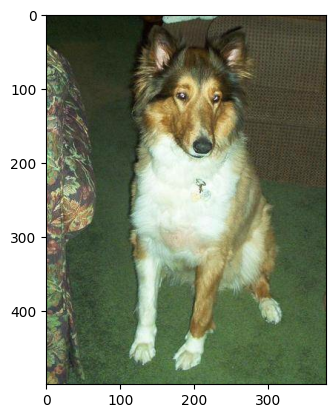

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted label: 1


In [ ]:
# plt.imshow(x_test[47].reshape(28, 28), cmap='gray')
# plt.title(f'Label: {y_test[47]}')
# plt.show()

# y_pred = model.predict(x_test[47][np.newaxis, :, :, :])
# print(f'Predicted label: {np.argmax(y_pred)}')

showImage = tf.io.read_file('test/0.1047.jpg')   # read the raw data from the file as a string
showImage = tf.image.decode_jpeg(showImage)  # decode the jpeg image to a tensor
plt.imshow(showImage)   # show the image
plt.show()

# prepare the image for the model
showImage = tf.image.resize(showImage, [128, 128])  # resize the image to 128x128
showImage = tf.cast(showImage, tf.float32) / 255.0  # transform the image to a tf.float32 type and normalize it to [0, 1]
showImage = showImage[tf.newaxis, :, :, :]  # add a batch dimension
predict = model.predict(showImage)  # predict the label of the image
print(f'Predicted label: {np.argmax(predict)}')    # print the predicted label